# Using the LLaVa-NeXT-Video model for video-to-text tasks on Amazon SageMaker Realtime Endpoint with PyTorch DLC

❗This notebook works well with the `PyTorch 2.2.0 Python 3.10 CPU Optimized` kernel on a SageMaker Studio `ml.t3.medium` instance.

## Set up Environment

In [ ]:
%%capture --no-stderr

!pip install -U pip
!pip install -U "sagemaker>=2.221.1"

!pip install -U transformers==4.42.3

# we need av to be able to read the video
!pip install -U av==12.2.0

In [ ]:
!pip freeze | grep -E "av|sagemaker|torch|transformers"

In [ ]:
import boto3
import sagemaker


region = boto3.Session().region_name
role = sagemaker.get_execution_role()

sess = sagemaker.Session()
bucket = sess.default_bucket()

## Upload the `model.tar.gz`

In order to use a custome inference script, create and upload dummy `model.tar.gz` to our sagemaker session bucket.

In [ ]:
%%time

!rm -f dummy-model.tar.gz
!mkdir -p model

# Create SageMaker model.tar.gz artifact
!tar --exclude "*/.ipynb_checkpoints*" -czvf dummy-model.tar.gz -C model .
!tar -tvf dummy-model.tar.gz
!ls -lh dummy-model.tar.gz

In [ ]:
HF_MODEL_ID = 'llava-hf/LLaVA-NeXT-Video-7B-hf'

base_name = HF_MODEL_ID.split('/')[-1].replace('.', '-').lower()

In [ ]:
from sagemaker.s3 import S3Uploader

# upload model.tar.gz to s3
s3_model_uri = S3Uploader.upload(
    local_path="./dummy-model.tar.gz",
    desired_s3_uri=f"s3://{bucket}/{base_name}"
)

In [ ]:
!aws s3 ls {s3_model_uri}

## Deploy LLaVa-NeXT-Video model to SageMaker Realtime Endpoint

In [ ]:
%%sh

# copy the custom inference script into the working directory
cp -rp ../python/code ./

In [ ]:
# Hub Model configuration. https://huggingface.co/models
hub = {
  'HF_MODEL_ID': 'llava-hf/LLaVA-NeXT-Video-7B-hf',
  'HF_TASK': 'image-to-text' # The pipeline tag "video-text-to-text" is not in the official list
}

In [ ]:
from sagemaker.utils import name_from_base
from sagemaker.pytorch import PyTorchModel


model_name = name_from_base(base_name)

pytorch_model = PyTorchModel(
    name=model_name,
    model_data=s3_model_uri,
    role=role,
    entry_point="inference.py",
    source_dir="code",
    framework_version="2.3.0",
    py_version="py311",
    env={
        **hub,

         #XXX: In order to avoid timeout when torchserver starting
        'SAGEMAKER_TS_RESPONSE_TIMEOUT': '600',
    }
)

In [ ]:
%%time

from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(base_name)
instance_type = 'ml.g5.xlarge'

predictor = pytorch_model.deploy(
    endpoint_name=endpoint_name,
    initial_instance_count=1,
    instance_type=instance_type,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

-------------!CPU times: user 630 ms, sys: 68.3 ms, total: 698 ms
Wall time: 7min 4s


In [ ]:
predictor.serializer, predictor.deserializer, predictor.content_type, predictor.endpoint_name

## Download Sample Data

In [ ]:
import sys

sys.path.append('code')

from inference import read_video_from_url

In [ ]:
karate_video_url = 'https://huggingface.co/datasets/raushan-testing-hf/videos-test/resolve/main/karate.mp4'

clip_karate = read_video_from_url(karate_video_url, sampling_rate=8)

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = clip_karate

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=100)
HTML(anim.to_html5_video())

## Run Inference by passing Video URL

In [ ]:
karate_video_url = 'https://huggingface.co/datasets/raushan-testing-hf/videos-test/resolve/main/karate.mp4'

prompt_video1 = 'USER: <video>\nWhat do you see in this video? ASSISTANT:'
generate_kwargs = {"max_new_tokens": 100, "do_sample": True, "top_p": 0.9}

video_data = {
    "inputs": [karate_video_url],
    "parameters": {
        "prompts": [prompt_video1],
        "generate_kwargs": generate_kwargs
    }
}

try:
    response = predictor.predict(data=video_data)
    print(response)
except Exception as ex:
    import traceback
    traceback.print_exc()

['USER: \nWhat do you see in this video? ASSISTANT: The video shows a man dressed in a martial arts outfit, possibly for training or practicing martial arts. He is seen holding a weapon in his hand, which looks like a staff or a part of a staff weapon, such as a jō-do-jō or a staff used in various martial arts disciplines. The man is performing what appears to be a technique or exercise, either for strength training or for martial arts training. The setting seems to be a do']


## Run Inference by passing Image URL

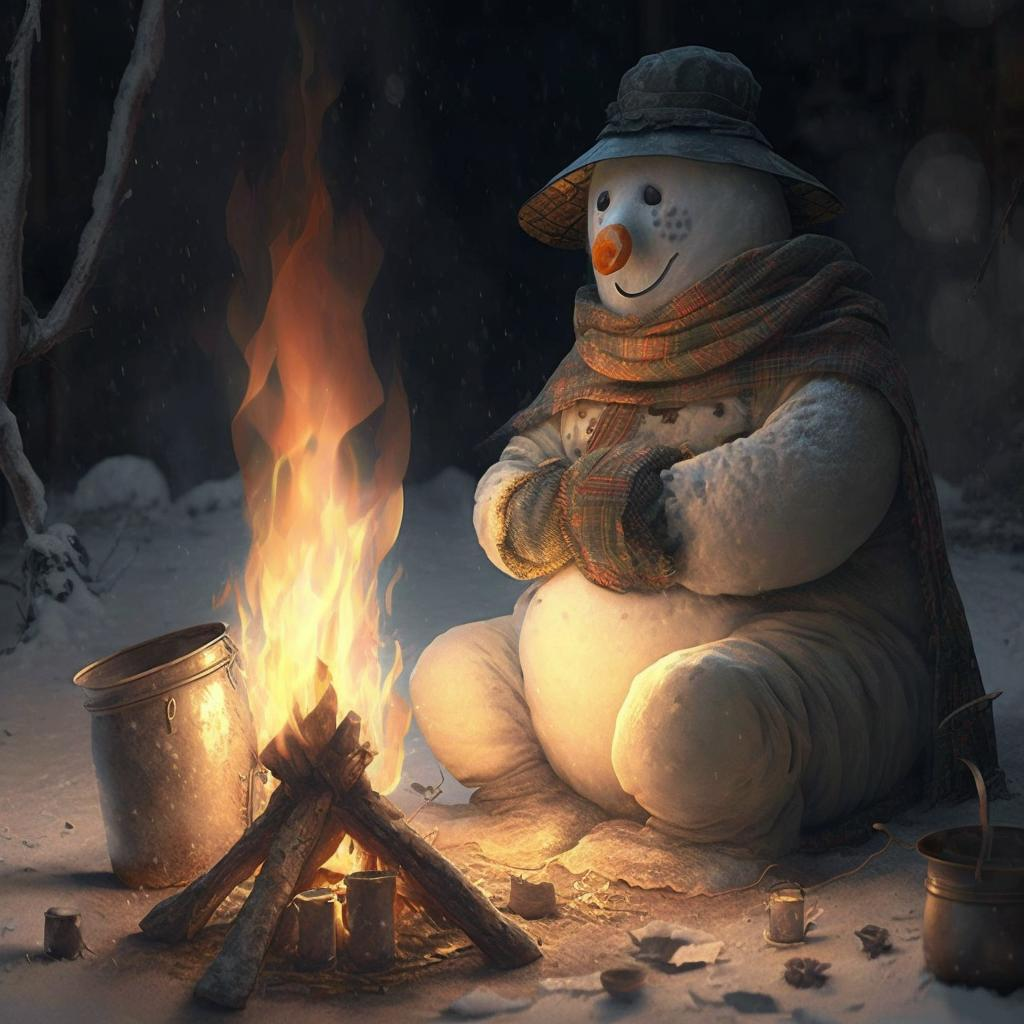

In [ ]:
import requests
from PIL import Image

image_snowman_url = 'https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.jpg'
image_snowman = Image.open(requests.get(image_snowman_url, stream=True).raw)
image_snowman

In [ ]:
image_snowman_url = 'https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.jpg'

prompt_image1 = 'USER: <image>\nWhat do you see in this image? ASSISTANT:'
generate_kwargs = {"max_new_tokens": 100, "do_sample": True, "top_p": 0.9}

image_data = {
    "inputs": [image_snowman_url],
    "parameters": {
        "prompts": [prompt_image1],
        "generate_kwargs": generate_kwargs
    }
}

try:
    response = predictor.predict(data=image_data)
    print(response)
except Exception as ex:
    import traceback
    traceback.print_exc()

['USER: \nWhat do you see in this image? ASSISTANT: The image features a character that appears to be a snowman. It is sitting on the ground next to a small campfire, which is likely a central theme of the story. The snowman is wearing a hat, a scarf, and has a small pail and a stick, which are typical accessories for a snowman. Behind the snowman, there is a background that suggests a snowy environment, possibly from a winter setting. There are trees and a dark, cold']


# Run Inference by passing base63 encoded Image

In [ ]:
import base64
from io import BytesIO

def pil_image_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
    return img_str

In [ ]:
encoded_image = pil_image_to_base64(image_snowman)

prompt_encoded_image = 'USER: <image>\nWhat do you see in this image? ASSISTANT:'
generate_kwargs = {"max_new_tokens": 100, "do_sample": True, "top_p": 0.9}

encoded_image_data = {
    "inputs": [encoded_image],
    "parameters": {
        "prompts": [prompt_encoded_image],
        "generate_kwargs": generate_kwargs
    }
}

try:
    response = predictor.predict(data=encoded_image_data)
    print(response)
except Exception as ex:
    import traceback
    traceback.print_exc()

['USER: \nWhat do you see in this image? ASSISTANT: The image features an animated snowman sitting in front of a fire. The snowman is wearing a hat, scarf, and has a carrot nose. There are also various items on the ground, such as a small cup and a small teapot, and the fire is surrounded by twigs and appears to be burning. The background is a snowy landscape with a dark sky, suggesting that this scene might be from a story or animation set during winter. The snowman seems to']


# Generate from image+video data

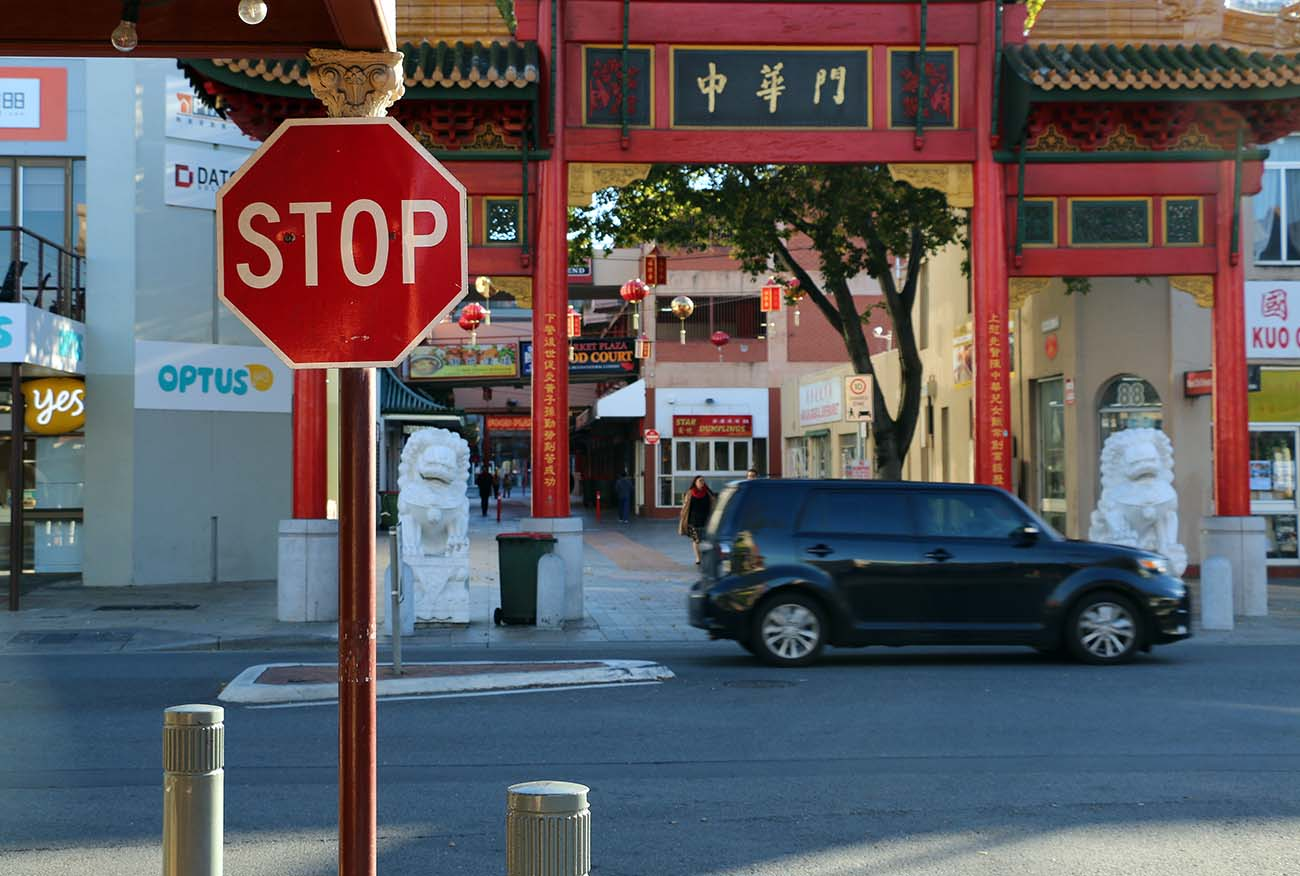

In [ ]:
import requests
from PIL import Image

image_stopsign_url = 'https://www.ilankelman.org/stopsigns/australia.jpg'
image_stopsign = Image.open(requests.get(image_stopsign_url, stream=True).raw)
image_stopsign

In [ ]:
karate_video_url = 'https://huggingface.co/datasets/raushan-testing-hf/videos-test/resolve/main/karate.mp4'
prompt_video1 = 'USER: <video>\nWhat do you see in this video? ASSISTANT:'

image_snowman_url = 'https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.jpg'
prompt_image1 = 'USER: <image>\nWhat do you see in this image? ASSISTANT:'

image_stopsign_url = 'https://www.ilankelman.org/stopsigns/australia.jpg'
prompt_image2 = 'USER: <image>\nWhat color is the sign? ASSISTANT:'

generate_kwargs = {"max_new_tokens": 100, "do_sample": True, "top_p": 0.9}

mixed_data = {
    "inputs": [karate_video_url, image_snowman_url, image_stopsign_url],
    "parameters": {
        "prompts": [prompt_video1, prompt_image1, prompt_image2],
        "generate_kwargs": generate_kwargs
    }
}

try:
    response = predictor.predict(data=mixed_data)
    print(response)
except Exception as ex:
    import traceback
    traceback.print_exc()

['USER: \nWhat do you see in this video? ASSISTANT: In this video, I see a person wearing a white martial arts uniform, likely a karate gi, practicing kata or a form on a tatami (a type of floor mat). The individual appears to be focusing on their technique, possibly executing a karate or martial arts move. The lighting is bright and the setting is indoors, suggesting that the practice might be taking place in a dojo or a dedicated martial arts training facility. The person', "USER: \nWhat do you see in this image? ASSISTANT: The image features a 3D-rendered snowman, who appears to be in a wintry setting. The snowman is wearing a cap and scarf, suggesting it's cold out. In the background, there's a roaring fire with a pot, suggesting it's nighttime. Snowflakes are falling from the sky, indicating a snowy environment. The setting includes various elements like a tree, a mug, a stick, and what appears to", 'USER: \nWhat color is the sign? ASSISTANT: The sign is red.']


# For multi-turn conversations, just continue stacking messages

In [ ]:
funny_video_url = 'https://huggingface.co/datasets/raushan-testing-hf/videos-test/resolve/main/sample_demo_1.mp4'

clip_funny = read_video_from_url(funny_video_url, sampling_rate=8)

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
video = clip_funny

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=100)
HTML(anim.to_html5_video())

In [ ]:
funny_video_url = 'https://huggingface.co/datasets/raushan-testing-hf/videos-test/resolve/main/sample_demo_1.mp4'

prompt_multiturn = 'USER: <video>\nWhat do you see in this video? ASSISTANT: I see a baby reading a book. USER: Why is it funny? ASSISTANT:'
generate_kwargs = {"max_new_tokens": 100, "do_sample": True, "top_p": 0.9}

video_data = {
    "inputs": [funny_video_url],
    "parameters": {
        "prompts": [prompt_multiturn],
        "generate_kwargs": generate_kwargs
    }
}

try:
    response = predictor.predict(data=video_data)
    print(response)
except Exception as ex:
    import traceback
    traceback.print_exc()

["USER: \nWhat do you see in this video? ASSISTANT: I see a baby reading a book. USER: Why is it funny? ASSISTANT: The baby is wearing glasses which is a humorous element because it looks at the camera with a confused or contemplative expression, and then tries to eat the book, which is amusing because it's unexpected and silly. The baby's innocence and the unexpected action adds to the humor."]


## Clean Up

To avoid incurring future charges, delete the resources.

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()

# References

- [LLaVa-NeXT-Video Model Card](https://huggingface.co/llava-hf/LLaVA-NeXT-Video-7B-hf)
- [llava-hf/LLaVA-NeXT-Video-7B-hf](https://huggingface.co/llava-hf/LLaVA-NeXT-Video-7B-hf): make sure to have `transformers >= 4.42.0`.